# Quick guide to correct a single S1 SLC burst with the S1-ETAD product

This guide should provide the basic steps which need to be performed to correct a single Sentinel-1 SLC burst with the timings provided in the S1-ETAD product.

For detailed explanations of the product format and grid definition, please consult the "Product Format Specification" Document (ETAD-DLR-PS-0014) v1.2.

All required information for timing correction is contained in the NetCDF product. The XML annotation can be consulted for informative purposes.

## Notebook setup

In [50]:
%matplotlib inline

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import sys

sys.path.append("../..")

In [53]:
import datetime

import numpy as np
from scipy.constants import c
from matplotlib import pyplot as plt

## 1. Select a burst of a S1-SLC product and extract relevant parameters

The following parameters have been extracted by the S1 product:

* S1A_IW_ETA__AXDV_20230806T211729_20230806T211757_049760_05FBCB_9DD6.SAFE

In particular it has been used the annotation file:

* annotation/S1A_IW_ETA__AXDV_20230806T211729_20230806T211757_049760_05FBCB.xml

In [54]:
swath_name = "IW1"
burst_t0 = datetime.datetime.fromisoformat("2023-08-06T21:17:34.771928")
burst_tau0 = 5.334431164884956e-03
burst_dt = 2.055556299999998e-03
burst_range_pixel_spacing = 2.329562
burst_dtau = burst_range_pixel_spacing / (c / 2)
burst_lines = 1494
burst_samples = 20843

burst_duration = burst_lines * burst_dt
burst_center = burst_t0 + datetime.timedelta(
    seconds=0.5 * burst_lines * burst_dt
)
t_ref = burst_center

In [55]:
print("Burst parameters")
print("t0:            ", burst_t0)
print("tau0:          ", burst_tau0)
print("dt:            ", burst_dt)
print("dtau:          ", burst_dtau)
print("lines:         ", burst_lines)
print("sammples:      ", burst_samples)
print("burst duration:", burst_duration)
print("reference time:", t_ref, "(burst center, arbitrary choice)")

Burst parameters
t0:             2023-08-06 21:17:34.771928
tau0:           0.005334431164884956
dt:             0.002055556299999998
dtau:           1.554116481475995e-08
lines:          1494
sammples:       20843
burst duration: 3.071001112199997
reference time: 2023-08-06 21:17:36.307429 (burst center, arbitrary choice)


## 2. Extract the relevant timing information from the ETAD product

The NetCDF file is structured in hierarchical groups.
The first level contains groups for each sub-swath (i.e. IW1-IW3 for IW mode).
Each swath group is further divided into groups for the individual Bursts which are named and ordered according to their acquisition start time.

The overall organization of the product is reflected by the Python API provided by the ``s1etad`` package, but internal details of XML and NetCDF files are hidden.

### Load S1-ETAD product

Please refer to [s1etad quick start](https://s1etad.readthedocs.io/en/latest/quickstart.html) guide for more information about the installation procedure of the ``s1etad`` Python package.

In [56]:
import s1etad

In [57]:
filename = (
    "data/"
    "S1A_IW_ETA__AXDV_20230806T211729_20230806T211757_049760_05FBCB_9DD6.SAFE"
)

In [58]:
eta = s1etad.Sentinel1Etad(filename)

In [59]:
eta

Sentinel1Etad("data/S1A_IW_ETA__AXDV_20230806T211729_20230806T211757_049760_05FBCB_9DD6.SAFE")  # 0x79919b666d70
Number of Sentinel-1 slices: 1
Sentinel-1 products list:
  S1A_IW_SLC__1SDV_20230806T211729_20230806T211757_049760_05FBCB_BC56.SAFE
Number of swaths: 3
Swath list: IW1, IW2, IW3
Azimuth time:
  min: 2023-08-06 21:17:29.208211
  max: 2023-08-06 21:17:57.184751
Range time:
  min: 0.0053335639608434815
  max: 0.006389868212274445
Grid sampling:
  x: 8.131672451354599e-07
  y: 0.02932551319648094
  unit: s
Grid spacing:
  x: 200.0
  y: 200.0
  unit: m
Processing settings:
  troposphericDelayCorrection: True
  troposphericDelayCorrectionGradient: True
  ionosphericDelayCorrection: True
  solidEarthTideCorrection: True
  oceanTidalLoadingCorrection: True
  bistaticAzimuthCorrection: True
  dopplerShiftRangeCorrection: True
  FMMismatchAzimuthCorrection: True

### Query ETAD product

In [60]:
margin = 0.5
t0_query = burst_center - datetime.timedelta(
    seconds=(burst_duration + margin) / 2
)
t1_query = burst_center + datetime.timedelta(
    seconds=(burst_duration + margin) / 2
)

In [61]:
selection = eta.query_burst(
    swath="IW1", first_time=t0_query, last_time=t1_query
)

In [62]:
selection

,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
2,7,1,1,S1A_IW_SLC__1SDV_20230806T211729_20230806T2117...,IW1,2023-08-06 21:17:34.721407480,2023-08-06 21:17:37.888562906


### Get the burst object

In [63]:
swath = eta[swath_name]
burst = swath[selection.bIndex.values[0]]

In [64]:
burst

Sentinel1EtadBurst("/IW1/Burst0007")  0x79919b1e4a50
Swaths ID: IW1
Burst index: 7
Shape: (109, 402)
Sampling start:
  x: 0.0
  y: 5.513196480938419
  units: s
Sampling:
  x: 8.131672451354599e-07
  y: 0.02932551319648094
  units: s

### Compute ETAD time grids for the selected burst

#### Start time computation

The burst group contains range and azimuth start times which need to be calculated:
```
Az = rootGroup:azimuthTimeMin + burst:gridStartAzimuthTime
Rg = rootGroup:rangeTimeMin + burst:gridStartRangeTime
```

The above formula corresponds to the following expression when one uses the ``s1etad`` Python API:

In [65]:
eta_az_start = (
    eta.min_azimuth_time - t_ref
).total_seconds() + burst.sampling_start["y"]
eta_rg_start = eta.min_range_time + burst.sampling_start["x"]

**NOTE**: please note that the ``t_ref`` is used to be able to express ``eta_az_ax_start`` as a ``float``.

In [66]:
print("eta_az_start:", eta_az_start, 'sec (relative to "t_ref")')
print("eta_rg_start:", eta_rg_start, "sec")

eta_az_start: -1.586021519061581 sec (relative to "t_ref")
eta_rg_start: 0.0053335639608434815 sec


#### Grid axis computation

In [67]:
eta_az_ax = eta_az_start + np.arange(burst.lines) * burst.sampling["y"]
eta_rg_ax = eta_rg_start + np.arange(burst.samples) * burst.sampling["x"]

A simpler alternative is to use the ``burst.get_burst_grid`` method:

In [68]:
eta_az_ax_rel, eta_rg_ax_rel = burst.get_burst_grid()

In [69]:
eta_az_ax2 = (eta.min_azimuth_time - t_ref).total_seconds() + eta_az_ax_rel
eta_rg_ax2 = eta.min_range_time + eta_rg_ax_rel

**NOTE**: in this case the ``burst.sampling_start`` is not used because it is already taken into account in ``burst.get_burst_grid``.

### Extraction of correction data

The relevant timing corrections are named (in the NetCDF file):

* sumOfCorrectionsRg
* sumOfCorrectionsAz

They can be accessed with the Python API as follows:

In [70]:
corrections = burst.get_correction(s1etad.ECorrectionType.SUM)
rg_correction = corrections["x"]
az_correction = corrections["y"]

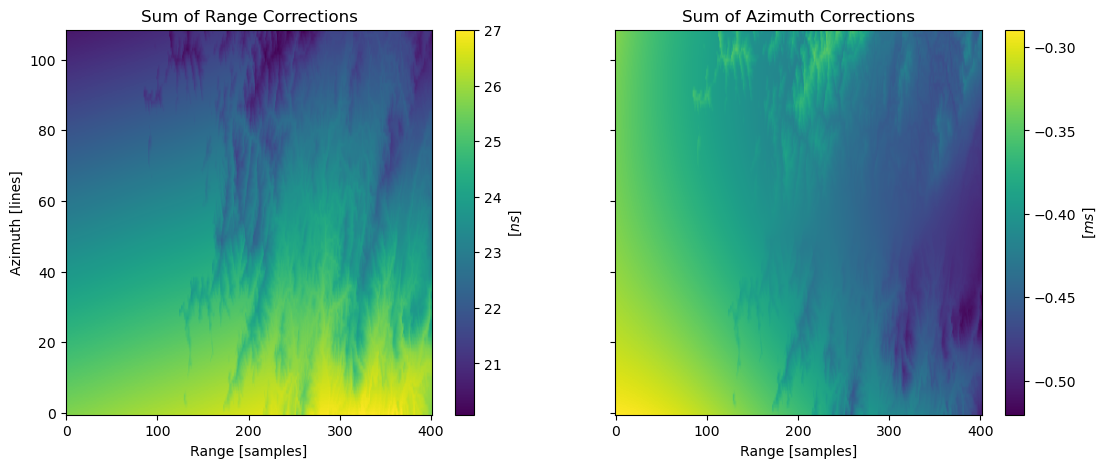

In [71]:
fig, ax = plt.subplots(1, 2, figsize=[13, 5], sharex=True, sharey=True)

img = ax[0].imshow(rg_correction * 1e9, aspect="auto", origin="lower")
ax[0].set_title("Sum of Range Corrections")
ax[0].set_xlabel("Range [samples]")
ax[0].set_ylabel("Azimuth [lines]")
fig.colorbar(img, ax=ax[0]).set_label(r"$[ns]$")

img = ax[1].imshow(az_correction * 1e3, aspect="auto", origin="lower")
ax[1].set_title("Sum of Azimuth Corrections")
ax[1].set_xlabel("Range [samples]")
# ax[1].set_ylabel('Azimuth [lines]')
fig.colorbar(img, ax=ax[1]).set_label(r"$[ms]$")

## 3. Resample the regularly sampled ETAD burst grids onto the regularly sampled S1-SLC grid with a bi-linear interpolation

Azimuth times $t$ and range times $\tau$ of the burst grid are defined by the following NetCDF parameters:

```
Az = rootGroup:azimuthTimeMin + burst:gridStartAzimuthTime + burst:azimuth
Rg = rootGroup:rangeTimeMin   + burst:gridStartRangeTime   + burst:range
```

The relevant ETAD NetCDF corrections which need to be applied are:


* sumOfCorrectionsRg: $\Delta_{\tau}(t, \tau)$
* sumOfCorrectionsAz: $\Delta_{t}(t, \tau)$

### Computation of the regularly sampled S1-SLC grid

In [72]:
burst_t0_sec = (burst_t0 - t_ref).total_seconds()
slc_az_ax = burst_t0_sec + np.arange(burst_lines) * burst_dt
slc_rg_ax = burst_tau0 + np.arange(burst_samples) * burst_dtau

slc_rg, slc_az = np.meshgrid(slc_rg_ax, slc_az_ax)

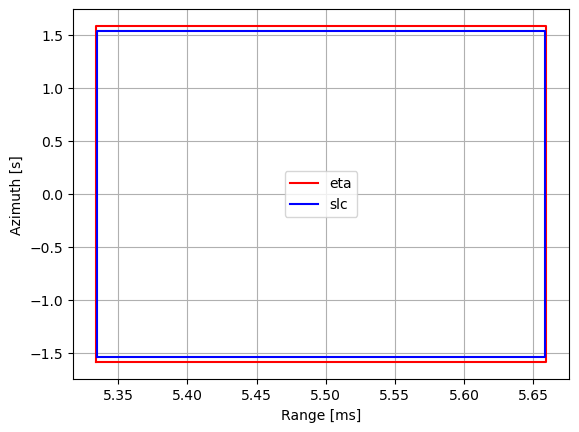

In [73]:
eta_box = np.asarray([
    (eta_rg_ax[0], eta_az_ax[0]),
    (eta_rg_ax[0], eta_az_ax[-1]),
    (eta_rg_ax[-1], eta_az_ax[-1]),
    (eta_rg_ax[-1], eta_az_ax[0]),
    (eta_rg_ax[0], eta_az_ax[0]),
])
slc_box = np.asarray([
    (slc_rg_ax[0], slc_az_ax[0]),
    (slc_rg_ax[0], slc_az_ax[-1]),
    (slc_rg_ax[-1], slc_az_ax[-1]),
    (slc_rg_ax[-1], slc_az_ax[0]),
    (slc_rg_ax[0], slc_az_ax[0]),
])

fix, ax = plt.subplots()
ax.plot(eta_box[:, 0] * 1e3, eta_box[:, 1], "r", label="eta")
ax.plot(slc_box[:, 0] * 1e3, slc_box[:, 1], "b", label="slc")
ax.set_xlabel("Range [ms]")
ax.set_ylabel("Azimuth [s]")
ax.legend()
ax.grid()

### Grid resampling

In [74]:
from scipy.interpolate import RectBivariateSpline

rg_corr_interpolator = RectBivariateSpline(
    eta_az_ax, eta_rg_ax, rg_correction, kx=1, ky=1
)  # bi-linear
az_corr_interpolator = RectBivariateSpline(
    eta_az_ax, eta_rg_ax, az_correction, kx=1, ky=1
)  # bi-linear

delta_tau = rg_corr_interpolator(slc_az_ax, slc_rg_ax)
delta_t = az_corr_interpolator(slc_az_ax, slc_rg_ax)

## 4. Subtract the resampled range corrections $\Delta_{\tau}(t, \tau)$ from the S1-SLC range times

In [75]:
slc_rg -= delta_tau

## 5. Subtract the resampled azimuth corrections $\Delta_{t}(t, \tau)$ from the S1-SLC azimuth times

In [76]:
slc_az -= delta_t

## 6. The result is an irregularly spaced burst grid with corrected timings for the S1 SLC data

**NOTE**: dummy synthetic (float) data are used just to demonstrate the procedure.

In [77]:
burst_slc = np.linspace(0, 1, burst_lines).reshape(
    burst_lines, 1
) + np.linspace(0, 1, burst_samples)

**NOTE**: in this example it is used a standard scipy interpolator. In a real use case a proper interpolator for complex interferometric data shall be used.

**NOTE**: the interpolation step is very slow. To reduce the computation time data are sub-sampled in the range direction.

In [78]:
from scipy.interpolate import RectBivariateSpline

subsamp = 10
slc_interpolator = RectBivariateSpline(
    slc_az_ax, slc_rg_ax[::subsamp], burst_slc[:, ::subsamp]
)

In [79]:
interpolated_slc = slc_interpolator(
    slc_az[:, ::subsamp], slc_rg[:, ::subsamp], grid=False
)

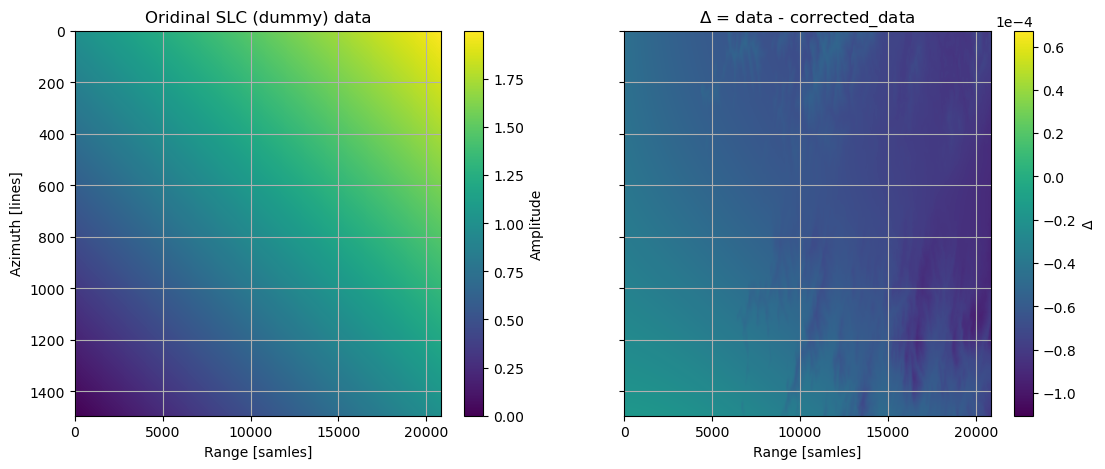

In [80]:
extent = (0, burst_samples, burst_lines, 0)

fig, ax = plt.subplots(1, 2, figsize=[13, 5], sharex=True, sharey=True)

img = ax[0].imshow(
    burst_slc[:, ::subsamp], aspect="auto", origin="lower", extent=extent
)
ax[0].set_title("Oridinal SLC (dummy) data")
ax[0].set_xlabel("Range [samles]")
ax[0].set_ylabel("Azimuth [lines]")
ax[0].grid()
fig.colorbar(img, ax=ax[0]).set_label("Amplitude")

img = ax[1].imshow(
    burst_slc[:, ::subsamp] - interpolated_slc,
    aspect="auto",
    origin="lower",
    extent=extent,
)
ax[1].set_title(r"$\Delta$ = data - corrected_data")
ax[1].set_xlabel("Range [samles]")
# ax[1].set_ylabel('Azimuth [lines]')
ax[1].grid()
cb = fig.colorbar(img, ax=ax[1])
cb.set_label(r"$\Delta$")
cb.formatter.set_scientific(True)
cb.formatter.set_powerlimits((0, 0))